<a href="https://colab.research.google.com/github/piabona/Dacon-Kaggle/blob/main/JEJU/%E1%84%8C%E1%85%A6%E1%84%8C%E1%85%AE_%E1%84%90%E1%85%B3%E1%86%A8%E1%84%89%E1%85%A1%E1%86%AB%E1%84%86%E1%85%AE%E1%86%AF_ML01_Ensemble_(797_10784).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [ ]:
!pip install flaml

In [ ]:
!pip install catboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/예슬 개인 참가/제주 특산물 가격 예측/data/'

In [ ]:
SEED = 42

In [ ]:
train = pd.read_csv(f'{DATA_PATH}train.csv')
test = pd.read_csv(f'{DATA_PATH}test.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
trade = pd.read_csv(f'{DATA_PATH}international_trade.csv')

In [ ]:
train.shape, test.shape, submission.shape, trade.shape

((59397, 7), (1092, 5), (1092, 2), (1274, 7))

# Feature engineering

In [ ]:
train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


In [ ]:
test

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J
...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J
1088,RD_F_J_20230328,2023-03-28,RD,F,J
1089,RD_F_J_20230329,2023-03-29,RD,F,J
1090,RD_F_J_20230330,2023-03-30,RD,F,J


- 39개 상품별 고유값 이름

In [ ]:
train['name'] = train['ID'].apply(lambda x: x[:6])
test['name'] = test['ID'].apply(lambda x: x[:6])

In [ ]:
train.rename(columns={'supply(kg)': 'supply_kg'}, inplace=True)
train.rename(columns={'price(원/kg)': 'price'}, inplace=True)


## 시간 관련
- 연, 월, 일 추가
- 요일 추가
- 연중 일자 추가 (day by year)
- 연중 주간 추가 (week by year)
- 주말/공휴일 여부 추가
- 성수기 vs 비수기 여부 추가


In [ ]:
# 'timestamp' 칼럼을 datetime 형식으로 변환
train['timestamp'] = pd.to_datetime(train['timestamp'])

# 연, 월, 일, 요일, 연중 일, 연중 주간 추출 및 칼럼 추가
train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['day'] = train['timestamp'].dt.day
train['week'] = train['timestamp'].dt.week

train['day_of_week'] = train['timestamp'].dt.dayofweek  # 월요일(0)부터 일요일(6)까지
train['day_of_year'] = train['timestamp'].dt.dayofyear  # 연중 일
train['week_of_year'] = train['timestamp'].dt.isocalendar().week  # 연중 주간 (ISO 주차 기준)

# 주말 여부 칼럼 추가 (0: 주중, 1: 주말)
train['is_weekend'] = train['timestamp'].dt.weekday // 5

# 계절 칼럼 추가 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)
def get_season(month):
    if 3 <= month <= 5:
        return 1  # 봄
    elif 6 <= month <= 8:
        return 2  # 여름
    elif 9 <= month <= 11:
        return 3  # 가을
    else:
        return 4  # 겨울

train['season'] = train['month'].apply(get_season)

train.head(5)

<ipython-input-95-946d3fe66a37>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['week'] = train['timestamp'].dt.week


,ID,timestamp,item,corporation,location,supply_kg,price,name,year,month,day,week,day_of_week,day_of_year,week_of_year,is_weekend,season
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,TG_A_J,2019,1,1,1,1,1,1,0,4
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,TG_A_J,2019,1,2,1,2,2,1,0,4
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,3,1,3,3,1,0,4
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,4,1,4,4,1,0,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,5,1,5,5,1,1,4


In [ ]:
# 'timestamp' 칼럼을 datetime 형식으로 변환
test['timestamp'] = pd.to_datetime(test['timestamp'])

# 연, 월, 일, 요일, 연중 일, 연중 주간 추출 및 칼럼 추가
test['year'] = test['timestamp'].dt.year
test['month'] = test['timestamp'].dt.month
test['day'] = test['timestamp'].dt.day
test['week'] = test['timestamp'].dt.week

test['day_of_week'] = test['timestamp'].dt.dayofweek  # 월요일(0)부터 일요일(6)까지
test['day_of_year'] = test['timestamp'].dt.dayofyear  # 연중 일
test['week_of_year'] = test['timestamp'].dt.isocalendar().week  # 연중 주간 (ISO 주차 기준)

# 주말 여부 칼럼 추가 (0: 주중, 1: 주말)
test['is_weekend'] = test['timestamp'].dt.weekday // 5

# 계절 칼럼 추가 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)
def get_season(month):
    if 3 <= month <= 5:
        return 1  # 봄
    elif 6 <= month <= 8:
        return 2  # 여름
    elif 9 <= month <= 11:
        return 3  # 가을
    else:
        return 4  # 겨울

test['season'] = test['month'].apply(get_season)

test.head(5)

<ipython-input-96-0afb7369f130>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test['week'] = test['timestamp'].dt.week


,ID,timestamp,item,corporation,location,name,year,month,day,week,day_of_week,day_of_year,week_of_year,is_weekend,season
0,TG_A_J_20230304,2023-03-04,TG,A,J,TG_A_J,2023,3,4,9,5,63,9,1,1
1,TG_A_J_20230305,2023-03-05,TG,A,J,TG_A_J,2023,3,5,9,6,64,9,1,1
2,TG_A_J_20230306,2023-03-06,TG,A,J,TG_A_J,2023,3,6,10,0,65,10,0,1
3,TG_A_J_20230307,2023-03-07,TG,A,J,TG_A_J,2023,3,7,10,1,66,10,0,1
4,TG_A_J_20230308,2023-03-08,TG,A,J,TG_A_J,2023,3,8,10,2,67,10,0,1


## 가격 관련 (price)
- 가격 평균은 모두, 상품별로 구함. 상품별, week별 가격 평균 등

- 요일별 가격 평균
- 성수기 vs 비수기별 가격 평균 *****
- 주별/월별/연별/계절별 가격 평균


In [ ]:
test['price'] = 0

In [ ]:
name_weekly_avg_price = train.groupby(['name', 'week'])['price'].mean().reset_index()
name_weekly_avg_price  #2067 데이터
name_monthly_avg_price = train.groupby(['name', 'month'])['price'].mean().reset_index()
name_monthly_avg_price #468데이터
name_yearly_avg_price = train.groupby(['name', 'year'])['price'].mean().reset_index()
name_yearly_avg_price #195데이터
name_season_avg_price = train.groupby(['name', 'season'])['price'].mean().reset_index()
name_season_avg_price.shape #156 데이터

(156, 3)

In [ ]:
name_day_of_week_avg_price = train.groupby(['name', 'day_of_week'])['price'].mean().reset_index()
name_day_of_week_avg_price.shape #273 데이터
name_day_of_year_avg_price = train.groupby(['name', 'day_of_year'])['price'].mean().reset_index()
name_day_of_year_avg_price.shape #14274 데이터
name_week_of_year_avg_price = train.groupby(['name', 'week_of_year'])['price'].mean().reset_index()
name_week_of_year_avg_price.shape #2067 데이터


(2067, 3)

In [ ]:
# 주간 평균 가격을 추가
train = train.merge(name_weekly_avg_price, on=['name', 'week'], how='left', suffixes=('', '_weekly_avg_price'))

# 월간 평균 가격을 추가
train = train.merge(name_monthly_avg_price, on=['name', 'month'], how='left', suffixes=('', '_monthly_avg_price'))

# 연간 평균 가격을 추가
train = train.merge(name_yearly_avg_price, on=['name', 'year'], how='left', suffixes=('', '_yearly_avg_price'))

# 계절별 평균 가격을 추가
train = train.merge(name_season_avg_price, on=['name', 'season'], how='left', suffixes=('', '_season_avg_price'))

# 요일별 평균 가격을 추가
train = train.merge(name_day_of_week_avg_price, on=['name', 'day_of_week'], how='left', suffixes=('', '_day_of_week_avg_price'))

# 연중 일자별 평균 가격을 추가
train = train.merge(name_day_of_year_avg_price, on=['name', 'day_of_year'], how='left', suffixes=('', '_day_of_year_avg_price'))

# 연중 주차별 평균 가격을 추가
train = train.merge(name_week_of_year_avg_price, on=['name', 'week_of_year'], how='left', suffixes=('', '_week_of_year_avg_price'))


In [ ]:
# 주간 평균 가격을 추가
test = test.merge(name_weekly_avg_price, on=['name', 'week'], how='left', suffixes=('', '_weekly_avg_price'))

# 월간 평균 가격을 추가
test = test.merge(name_monthly_avg_price, on=['name', 'month'], how='left', suffixes=('', '_monthly_avg_price'))

# 연간 평균 가격을 추가
test = test.merge(name_yearly_avg_price, on=['name', 'year'], how='left', suffixes=('', '_yearly_avg_price'))

# 계절별 평균 가격을 추가
test = test.merge(name_season_avg_price, on=['name', 'season'], how='left', suffixes=('', '_season_avg_price'))

# 요일별 평균 가격을 추가
test = test.merge(name_day_of_week_avg_price, on=['name', 'day_of_week'], how='left', suffixes=('', '_day_of_week_avg_price'))

# 연중 일자별 평균 가격을 추가
test = test.merge(name_day_of_year_avg_price, on=['name', 'day_of_year'], how='left', suffixes=('', '_day_of_year_avg_price'))

# 연중 주차별 평균 가격을 추가
test = test.merge(name_week_of_year_avg_price, on=['name', 'week_of_year'], how='left', suffixes=('', '_week_of_year_avg_price'))


In [ ]:
# train['weekly_avg_price'] = train.groupby('week')['price'].apply(lambda x: x.mean())
# train['monthly_avg_price'] = train.groupby('month')['price'].apply(lambda x: x.mean())
# train['yearly_avg_price'] = train.groupby('year')['price'].apply(lambda x: x.mean())
# train['day_of_week_avg_price'] = train.groupby('day_of_week')['price'].apply(lambda x: x.mean())
# train['day_of_year_avg_price'] = train.groupby('day_of_year')['price'].apply(lambda x: x.mean())
# train['week_of_year_avg_price'] = train.groupby('week_of_year')['price'].apply(lambda x: x.mean())
# train['weekend_avg_price'] = train.groupby('is_weekend')['price'].apply(lambda x: x.mean())
# train['season_avg_price'] = train.groupby('season')['price'].apply(lambda x: x.mean())


In [ ]:
train

,ID,timestamp,item,corporation,location,supply_kg,price,name,year,month,...,week_of_year,is_weekend,season,price_weekly_avg_price,price_monthly_avg_price,price_yearly_avg_price,price_season_avg_price,price_day_of_week_avg_price,price_day_of_year_avg_price,price_week_of_year_avg_price
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,1,0,4,1099.735294,1403.858065,1476.257534,1374.840476,2984.238532,0.0,1099.735294
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,1,0,4,1099.735294,1403.858065,1476.257534,1374.840476,2980.545872,0.0,1099.735294
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,1,0,4,1099.735294,1403.858065,1476.257534,1374.840476,3265.123853,1373.6,1099.735294
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,1,0,4,1099.735294,1403.858065,1476.257534,1374.840476,3038.880734,1767.2,1099.735294
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,1,1,4,1099.735294,1403.858065,1476.257534,1374.840476,2578.184332,1129.2,1099.735294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,9,0,4,373.666667,354.177305,404.758065,446.516667,310.520737,311.0,373.666667
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,9,0,4,373.666667,354.177305,404.758065,446.516667,317.376147,360.4,373.666667
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,9,0,1,373.666667,332.102362,404.758065,339.849057,306.174312,441.2,373.666667
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,9,0,1,373.666667,332.102362,404.758065,339.849057,297.178899,347.6,373.666667


In [ ]:
test

,ID,timestamp,item,corporation,location,name,year,month,day,week,...,is_weekend,season,price,price_weekly_avg_price,price_monthly_avg_price,price_yearly_avg_price,price_season_avg_price,price_day_of_week_avg_price,price_day_of_year_avg_price,price_week_of_year_avg_price
0,TG_A_J_20230304,2023-03-04,TG,A,J,TG_A_J,2023,3,4,9,...,1,1,0,2593.333333,3215.417323,1811.225806,3564.312668,2578.184332,2934.50,2593.333333
1,TG_A_J_20230305,2023-03-05,TG,A,J,TG_A_J,2023,3,5,9,...,1,1,0,2593.333333,3215.417323,1811.225806,3564.312668,7.359447,3372.00,2593.333333
2,TG_A_J_20230306,2023-03-06,TG,A,J,TG_A_J,2023,3,6,10,...,0,1,0,2563.142857,3215.417323,1811.225806,3564.312668,3116.041475,2380.25,2563.142857
3,TG_A_J_20230307,2023-03-07,TG,A,J,TG_A_J,2023,3,7,10,...,0,1,0,2563.142857,3215.417323,1811.225806,3564.312668,2984.238532,3093.50,2563.142857
4,TG_A_J_20230308,2023-03-08,TG,A,J,TG_A_J,2023,3,8,10,...,0,1,0,2563.142857,3215.417323,1811.225806,3564.312668,2980.545872,1879.00,2563.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J,RD_F_J,2023,3,27,13,...,0,1,0,327.464286,332.102362,404.758065,339.849057,310.520737,275.25,327.464286
1088,RD_F_J_20230328,2023-03-28,RD,F,J,RD_F_J,2023,3,28,13,...,0,1,0,327.464286,332.102362,404.758065,339.849057,317.376147,305.50,327.464286
1089,RD_F_J_20230329,2023-03-29,RD,F,J,RD_F_J,2023,3,29,13,...,0,1,0,327.464286,332.102362,404.758065,339.849057,306.174312,375.25,327.464286
1090,RD_F_J_20230330,2023-03-30,RD,F,J,RD_F_J,2023,3,30,13,...,0,1,0,327.464286,332.102362,404.758065,339.849057,297.178899,267.75,327.464286


## 유통물량 관련 (supply)
- 요일별 유통물량 평균
- 월별 유통물량 평균
- 주별 유통물량 평균
- 등등, 가격과 같은 개념으로 supply 정보를 추가하기

In [ ]:
#추가로 더해줘야 함 supply
test['supply_kg'] = 0

In [ ]:
# 'name' 별로 그룹화하여 그룹별 평균 가격 계산
name_weekly_avg_supply = train.groupby(['name', 'week'])['supply_kg'].mean().reset_index()
name_weekly_avg_supply  #2067 데이터
name_monthly_avg_supply = train.groupby(['name', 'month'])['supply_kg'].mean().reset_index()
name_monthly_avg_supply #468데이터
name_yearly_avg_supply = train.groupby(['name', 'year'])['supply_kg'].mean().reset_index()
name_yearly_avg_supply #195데이터
name_season_avg_supply = train.groupby(['name', 'season'])['supply_kg'].mean().reset_index()
name_season_avg_supply.shape #156 데이터

(156, 3)

In [ ]:
name_day_of_week_avg_supply = train.groupby(['name', 'day_of_week'])['supply_kg'].mean().reset_index()
name_day_of_week_avg_supply.shape #273 데이터
name_day_of_year_avg_supply = train.groupby(['name', 'day_of_year'])['supply_kg'].mean().reset_index()
name_day_of_year_avg_supply.shape #14274 데이터
name_week_of_year_avg_supply = train.groupby(['name', 'week_of_year'])['supply_kg'].mean().reset_index()
name_week_of_year_avg_supply.shape #2067 데이터


(2067, 3)

In [ ]:
# 주간 평균 유통물량을 추가
train = train.merge(name_weekly_avg_supply, on=['name', 'week'], how='left', suffixes=('', '_weekly_avg_supply'))

# 월간 평균 유통물량을 추가
train = train.merge(name_monthly_avg_supply, on=['name', 'month'], how='left', suffixes=('', '_monthly_avg_supply'))

# 연간 평균 유통물량을 추가
train = train.merge(name_yearly_avg_supply, on=['name', 'year'], how='left', suffixes=('', '_yearly_avg_supply'))

# 계절별 평균 유통물량을 추가
train = train.merge(name_season_avg_supply, on=['name', 'season'], how='left', suffixes=('', '_season_avg_supply'))

# 요일별 평균 유통물량을 추가
train = train.merge(name_day_of_week_avg_supply, on=['name', 'day_of_week'], how='left', suffixes=('', '_day_of_week_avg_supply'))

# 연중 일자별 평균 유통물량을 추가
train = train.merge(name_day_of_year_avg_supply, on=['name', 'day_of_year'], how='left', suffixes=('', '_day_of_year_avg_supply'))

# 연중 주차별 평균 유통물량을 추가
train = train.merge(name_week_of_year_avg_supply, on=['name', 'week_of_year'], how='left', suffixes=('', '_week_of_year_avg_supply'))


In [ ]:
# 주간 평균 유통물량을 추가
test = test.merge(name_weekly_avg_supply, on=['name', 'week'], how='left', suffixes=('', '_weekly_avg_supply'))

# 월간 평균 유통물량을 추가
test = test.merge(name_monthly_avg_supply, on=['name', 'month'], how='left', suffixes=('', '_monthly_avg_supply'))

# 연간 평균 유통물량을 추가
test = test.merge(name_yearly_avg_supply, on=['name', 'year'], how='left', suffixes=('', '_yearly_avg_supply'))

# 계절별 평균 유통물량을 추가
test = test.merge(name_season_avg_supply, on=['name', 'season'], how='left', suffixes=('', '_season_avg_supply'))

# 요일별 평균 유통물량을 추가
test = test.merge(name_day_of_week_avg_supply, on=['name', 'day_of_week'], how='left', suffixes=('', '_day_of_week_avg_supply'))

# 연중 일자별 평균 유통물량을 추가
test = test.merge(name_day_of_year_avg_supply, on=['name', 'day_of_year'], how='left', suffixes=('', '_day_of_year_avg_supply'))

# 연중 주차별 평균 유통물량을 추가
test = test.merge(name_week_of_year_avg_supply, on=['name', 'week_of_year'], how='left', suffixes=('', '_week_of_year_avg_supply'))


In [ ]:
train.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply_kg',
       'price', 'name', 'year', 'month', 'day', 'week', 'day_of_week',
       'day_of_year', 'week_of_year', 'is_weekend', 'season',
       'price_weekly_avg_price', 'price_monthly_avg_price',
       'price_yearly_avg_price', 'price_season_avg_price',
       'price_day_of_week_avg_price', 'price_day_of_year_avg_price',
       'price_week_of_year_avg_price', 'supply_kg_weekly_avg_supply',
       'supply_kg_monthly_avg_supply', 'supply_kg_yearly_avg_supply',
       'supply_kg_season_avg_supply', 'supply_kg_day_of_week_avg_supply',
       'supply_kg_day_of_year_avg_supply',
       'supply_kg_week_of_year_avg_supply'],
      dtype='object')

In [ ]:
test.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'name', 'year',
       'month', 'day', 'week', 'day_of_week', 'day_of_year', 'week_of_year',
       'is_weekend', 'season', 'price', 'price_weekly_avg_price',
       'price_monthly_avg_price', 'price_yearly_avg_price',
       'price_season_avg_price', 'price_day_of_week_avg_price',
       'price_day_of_year_avg_price', 'price_week_of_year_avg_price',
       'supply_kg', 'supply_kg_weekly_avg_supply',
       'supply_kg_monthly_avg_supply', 'supply_kg_yearly_avg_supply',
       'supply_kg_season_avg_supply', 'supply_kg_day_of_week_avg_supply',
       'supply_kg_day_of_year_avg_supply',
       'supply_kg_week_of_year_avg_supply'],
      dtype='object')

In [ ]:
train.isnull().sum()

ID                                   0
timestamp                            0
item                                 0
corporation                          0
location                             0
supply_kg                            0
price                                0
name                                 0
year                                 0
month                                0
day                                  0
week                                 0
day_of_week                          0
day_of_year                          0
week_of_year                         0
is_weekend                           0
season                               0
price_weekly_avg_price               0
price_monthly_avg_price              0
price_yearly_avg_price               0
price_season_avg_price               0
price_day_of_week_avg_price          0
price_day_of_year_avg_price          0
price_week_of_year_avg_price         0
supply_kg_weekly_avg_supply          0
supply_kg_monthly_avg_sup

## 무역 관련
- 감귤TG (10), 브로콜리BC (9), 무RD (8), 당근CR (7), 양배추CB (5)
- 품목별 해당 데이터 추가하기

In [ ]:
trade.columns = ['time','item','export_kg','export_price','import_kg','import_price','trade_balance']
trade

,time,item,export_kg,export_price,import_kg,import_price,trade_balance
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38
...,...,...,...,...,...,...,...
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0


In [ ]:
trade['time'] = pd.to_datetime(trade['time'])

trade['year'] = trade['time'].dt.year
trade['month'] = trade['time'].dt.month

In [ ]:
mask = trade['item'].str.contains('감귤')
tg_index = trade[mask][['item','year','month','export_kg','export_price','import_kg','import_price','trade_balance']]
tg_index['item'] = tg_index['item'].replace('감귤','TG')
tg_index

,item,year,month,export_kg,export_price,import_kg,import_price,trade_balance
17,TG,2019,1,58368,172,0,0,172
41,TG,2019,2,8474,33,0,0,33
64,TG,2019,3,2061,10,4599,12,-2
88,TG,2019,4,328,9,13457,36,-27
114,TG,2019,5,2560,21,0,0,21
140,TG,2019,6,3417,21,0,0,21
167,TG,2019,7,4603,27,0,0,27
194,TG,2019,8,5859,31,0,0,31
223,TG,2019,9,8050,39,0,0,39
248,TG,2019,10,3651,14,0,0,14


In [ ]:
mask = trade['item'].str.contains('브로콜리')
bc_index = trade[mask][['item','year','month','export_kg','export_price','import_kg','import_price','trade_balance']]
bc_index['item'] = bc_index['item'].replace('꽃양배추와 브로콜리(broccoli)','BC')
bc_index

,item,year,month,export_kg,export_price,import_kg,import_price,trade_balance
3,BC,2019,1,160,1,638913,563,-562
28,BC,2019,2,780,1,396870,399,-398
51,BC,2019,3,100,0,417756,503,-503
75,BC,2019,4,18,0,783593,1207,-1207
99,BC,2019,5,16,0,749745,1028,-1028
126,BC,2019,6,0,0,635122,684,-684
153,BC,2019,7,40,0,586192,671,-671
180,BC,2019,8,0,0,1389462,1618,-1618
207,BC,2019,9,0,0,1511178,1558,-1558
235,BC,2019,10,0,0,1478019,1378,-1378


In [ ]:
mask = trade['item'].str.contains('순무')
rd_index = trade[mask][['item','year','month','export_kg','export_price','import_kg','import_price','trade_balance']]
rd_index['item'] = rd_index['item'].replace('순무','RD')
rd_index

,item,year,month,export_kg,export_price,import_kg,import_price,trade_balance
536,RD,2020,10,450,8,0,0,8
681,RD,2021,4,577,0,0,0,0
705,RD,2021,5,312,0,0,0,0
732,RD,2021,6,130,0,0,0,0
861,RD,2021,11,0,0,1,0,0
1254,RD,2023,2,4000,4,2,0,4


In [ ]:
mask = trade['item'].str.contains('당근')
cr_index = trade[mask][['item','year','month','export_kg','export_price','import_kg','import_price','trade_balance']]
cr_index['item'] = cr_index['item'].replace('당근','CR')
cr_index

,item,year,month,export_kg,export_price,import_kg,import_price,trade_balance
8,CR,2019,1,23150,22,7466150,2955,-2934
33,CR,2019,2,16250,16,6524716,2600,-2585
56,CR,2019,3,17960,13,13353720,4953,-4941
80,CR,2019,4,16910,14,8323700,3493,-3479
104,CR,2019,5,18000,16,4897803,2160,-2144
130,CR,2019,6,19500,14,7853590,3601,-3587
158,CR,2019,7,17000,11,9570280,3817,-3806
185,CR,2019,8,18547,12,7232500,2690,-2679
212,CR,2019,9,15575,10,10404140,3839,-3829
240,CR,2019,10,17596,11,10531000,3151,-3139


In [ ]:
mask = trade['item'].isin(['양배추'])
cb_index = trade[mask][['item','year','month','export_kg','export_price','import_kg','import_price','trade_balance']]
cb_index['item'] = cb_index['item'].str.replace('양배추', 'CB', regex=True)
cb_index

,item,year,month,export_kg,export_price,import_kg,import_price,trade_balance
5,CB,2019,1,184650,94,395802,90,4
30,CB,2019,2,182636,69,336142,77,-8
53,CB,2019,3,854925,354,356514,94,260
77,CB,2019,4,6494616,2658,343463,105,2553
101,CB,2019,5,1461639,662,270972,95,567
128,CB,2019,6,3286366,1656,271444,69,1586
155,CB,2019,7,1676629,798,472041,119,679
182,CB,2019,8,2465625,1154,280140,73,1081
209,CB,2019,9,1187087,566,226329,60,507
237,CB,2019,10,201297,105,635187,151,-46


In [ ]:
train['item'].value_counts()

TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64

In [ ]:
merged_indices = pd.concat([tg_index, bc_index, rd_index, cr_index, cb_index], axis=0).reset_index().drop(columns='index')
merged_indices

,item,year,month,export_kg,export_price,import_kg,import_price,trade_balance
0,TG,2019,1,58368,172,0,0,172
1,TG,2019,2,8474,33,0,0,33
2,TG,2019,3,2061,10,4599,12,-2
3,TG,2019,4,328,9,13457,36,-27
4,TG,2019,5,2560,21,0,0,21
...,...,...,...,...,...,...,...,...
201,CB,2022,10,3926,7,672530,240,-233
202,CB,2022,11,13120,23,418180,121,-98
203,CB,2022,12,133572,84,299384,87,-3
204,CB,2023,1,216721,129,303960,85,44


In [ ]:
#item별 월별 평균값으로 바꾸기
# merged_indices에서 아이템별 월별 평균값 계산
item_monthly_avg = merged_indices.groupby(['item', 'month'], as_index=False).mean()
item_monthly_avg = item_monthly_avg.drop(columns = 'year')
item_monthly_avg

,item,month,export_kg,export_price,import_kg,import_price,trade_balance
0,BC,1,46.40,0.40,682774.20,751.80,-751.20
1,BC,2,423.20,1.00,403745.20,432.80,-431.80
2,BC,3,45.50,1.00,753128.50,819.50,-818.50
3,BC,4,33.50,0.25,890748.00,1106.00,-1105.75
4,BC,5,18.00,0.25,722724.25,856.25,-855.75
5,BC,6,12.00,0.00,513319.50,569.00,-569.00
6,BC,7,20.00,0.00,642013.25,744.00,-744.00
7,BC,8,8.25,0.00,1224899.75,1466.75,-1466.75
8,BC,9,6.00,0.00,1407729.00,1677.00,-1677.00
9,BC,10,6.00,0.00,971622.50,1081.00,-1081.00


In [ ]:
train

,ID,timestamp,item,corporation,location,supply_kg,price,name,year,month,...,price_day_of_week_avg_price,price_day_of_year_avg_price,price_week_of_year_avg_price,supply_kg_weekly_avg_supply,supply_kg_monthly_avg_supply,supply_kg_yearly_avg_supply,supply_kg_season_avg_supply,supply_kg_day_of_week_avg_supply,supply_kg_day_of_year_avg_supply,supply_kg_week_of_year_avg_supply
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,2984.238532,0.0,1099.735294,33714.341176,29435.214839,6084.346575,20589.331190,11043.781651,0.00,33714.341176
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,2980.545872,0.0,1099.735294,33714.341176,29435.214839,6084.346575,20589.331190,9264.023853,0.00,33714.341176
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,3265.123853,1373.6,1099.735294,33714.341176,29435.214839,6084.346575,20589.331190,10454.102294,37713.92,33714.341176
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,3038.880734,1767.2,1099.735294,33714.341176,29435.214839,6084.346575,20589.331190,9622.749541,42064.10,33714.341176
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,2578.184332,1129.2,1099.735294,33714.341176,29435.214839,6084.346575,20589.331190,9891.611982,46416.36,33714.341176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,310.520737,311.0,373.666667,376770.303030,336692.765957,345056.129032,302658.952381,242069.308756,327560.00,376770.303030
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,317.376147,360.4,373.666667,376770.303030,336692.765957,345056.129032,302658.952381,227022.660550,330140.00,376770.303030
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,306.174312,441.2,373.666667,376770.303030,377511.181102,345056.129032,385217.142857,220474.587156,362056.00,376770.303030
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,297.178899,347.6,373.666667,376770.303030,377511.181102,345056.129032,385217.142857,221479.449541,361960.00,376770.303030


In [ ]:
train = pd.merge(train, item_monthly_avg, on=['item', 'month'], how='left')
train

,ID,timestamp,item,corporation,location,supply_kg,price,name,year,month,...,supply_kg_yearly_avg_supply,supply_kg_season_avg_supply,supply_kg_day_of_week_avg_supply,supply_kg_day_of_year_avg_supply,supply_kg_week_of_year_avg_supply,export_kg,export_price,import_kg,import_price,trade_balance
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,6084.346575,20589.331190,11043.781651,0.00,33714.341176,192621.6,317.4,0.2,0.0,317.4
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,6084.346575,20589.331190,9264.023853,0.00,33714.341176,192621.6,317.4,0.2,0.0,317.4
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,6084.346575,20589.331190,10454.102294,37713.92,33714.341176,192621.6,317.4,0.2,0.0,317.4
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,6084.346575,20589.331190,9622.749541,42064.10,33714.341176,192621.6,317.4,0.2,0.0,317.4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,6084.346575,20589.331190,9891.611982,46416.36,33714.341176,192621.6,317.4,0.2,0.0,317.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,345056.129032,302658.952381,242069.308756,327560.00,376770.303030,4000.0,4.0,2.0,0.0,4.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,345056.129032,302658.952381,227022.660550,330140.00,376770.303030,4000.0,4.0,2.0,0.0,4.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,345056.129032,385217.142857,220474.587156,362056.00,376770.303030,NaN,NaN,NaN,NaN,NaN
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,345056.129032,385217.142857,221479.449541,361960.00,376770.303030,NaN,NaN,NaN,NaN,NaN


In [ ]:
test = pd.merge(test, item_monthly_avg, on=['item', 'month'], how='left')
test

,ID,timestamp,item,corporation,location,name,year,month,day,week,...,supply_kg_yearly_avg_supply,supply_kg_season_avg_supply,supply_kg_day_of_week_avg_supply,supply_kg_day_of_year_avg_supply,supply_kg_week_of_year_avg_supply,export_kg,export_price,import_kg,import_price,trade_balance
0,TG_A_J_20230304,2023-03-04,TG,A,J,TG_A_J,2023,3,4,9,...,13453.230645,1713.856334,9891.611982,3932.75,4861.481818,7207.5,33.75,4665.5,14.5,19.25
1,TG_A_J_20230305,2023-03-05,TG,A,J,TG_A_J,2023,3,5,9,...,13453.230645,1713.856334,200.253456,4421.00,4861.481818,7207.5,33.75,4665.5,14.5,19.25
2,TG_A_J_20230306,2023-03-06,TG,A,J,TG_A_J,2023,3,6,10,...,13453.230645,1713.856334,11568.029493,4138.50,3912.696429,7207.5,33.75,4665.5,14.5,19.25
3,TG_A_J_20230307,2023-03-07,TG,A,J,TG_A_J,2023,3,7,10,...,13453.230645,1713.856334,11043.781651,3424.50,3912.696429,7207.5,33.75,4665.5,14.5,19.25
4,TG_A_J_20230308,2023-03-08,TG,A,J,TG_A_J,2023,3,8,10,...,13453.230645,1713.856334,9264.023853,4555.25,3912.696429,7207.5,33.75,4665.5,14.5,19.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J,RD_F_J,2023,3,27,13,...,345056.129032,385217.142857,242069.308756,289720.00,406660.000000,NaN,NaN,NaN,NaN,NaN
1088,RD_F_J_20230328,2023-03-28,RD,F,J,RD_F_J,2023,3,28,13,...,345056.129032,385217.142857,227022.660550,346955.00,406660.000000,NaN,NaN,NaN,NaN,NaN
1089,RD_F_J_20230329,2023-03-29,RD,F,J,RD_F_J,2023,3,29,13,...,345056.129032,385217.142857,220474.587156,434880.00,406660.000000,NaN,NaN,NaN,NaN,NaN
1090,RD_F_J_20230330,2023-03-30,RD,F,J,RD_F_J,2023,3,30,13,...,345056.129032,385217.142857,221479.449541,291155.00,406660.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
train.to_csv('train_feature_v0.csv', index=False)
test.to_csv('test_feature_v0.csv', index=False)

In [ ]:
train.to_csv(f'{DATA_PATH}train_feature_v0.csv', index=False)
test.to_csv(f'{DATA_PATH}test_feature_v0.csv', index=False)

# 범주형 Feature 처리
- one hot? label? : item, corporation, location
- drop : ID, timestamp, name
- float 변환 : week of year

In [ ]:
cat_cols = ['item','corporation','location']
train = pd.get_dummies(train, columns=cat_cols)
test = pd.get_dummies(test, columns=cat_cols)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59397 entries, 0 to 59396
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   ID                                 59397 non-null  object        
 1   timestamp                          59397 non-null  datetime64[ns]
 2   supply_kg                          59397 non-null  float64       
 3   price                              59397 non-null  float64       
 4   name                               59397 non-null  object        
 5   year                               59397 non-null  int64         
 6   month                              59397 non-null  int64         
 7   day                                59397 non-null  int64         
 8   week                               59397 non-null  int64         
 9   day_of_week                        59397 non-null  int64         
 10  day_of_year                       

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 0 to 1091
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   ID                                 1092 non-null   object        
 1   timestamp                          1092 non-null   datetime64[ns]
 2   name                               1092 non-null   object        
 3   year                               1092 non-null   int64         
 4   month                              1092 non-null   int64         
 5   day                                1092 non-null   int64         
 6   week                               1092 non-null   int64         
 7   day_of_week                        1092 non-null   int64         
 8   day_of_year                        1092 non-null   int64         
 9   week_of_year                       1092 non-null   UInt32        
 10  is_weekend                         1

In [ ]:
mask = merged_indices['item'] == 'RD'
merged_indices[mask]

,item,year,month,export_kg,export_price,import_kg,import_price,trade_balance
100,RD,2020,10,450,8,0,0,8
101,RD,2021,4,577,0,0,0,0
102,RD,2021,5,312,0,0,0,0
103,RD,2021,6,130,0,0,0,0
104,RD,2021,11,0,0,1,0,0
105,RD,2023,2,4000,4,2,0,4


In [ ]:
f
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [ ]:
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


# Feature Selection ***

In [ ]:
target = train['price']
target

0           0.0
1           0.0
2        1728.0
3        1408.0
4        1250.0
          ...  
59392     468.0
59393     531.0
59394     574.0
59395     523.0
59396     529.0
Name: price, Length: 59397, dtype: float64

In [ ]:
train.shape, test.shape

((59397, 46), (1092, 46))

In [ ]:
train.columns

Index(['ID', 'timestamp', 'supply_kg', 'price', 'name', 'year', 'month', 'day',
       'week', 'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'season', 'price_weekly_avg_price', 'price_monthly_avg_price',
       'price_yearly_avg_price', 'price_season_avg_price',
       'price_day_of_week_avg_price', 'price_day_of_year_avg_price',
       'price_week_of_year_avg_price', 'supply_kg_weekly_avg_supply',
       'supply_kg_monthly_avg_supply', 'supply_kg_yearly_avg_supply',
       'supply_kg_season_avg_supply', 'supply_kg_day_of_week_avg_supply',
       'supply_kg_day_of_year_avg_supply', 'supply_kg_week_of_year_avg_supply',
       'export_kg', 'export_price', 'import_kg', 'import_price',
       'trade_balance', 'item_BC', 'item_CB', 'item_CR', 'item_RD', 'item_TG',
       'corporation_A', 'corporation_B', 'corporation_C', 'corporation_D',
       'corporation_E', 'corporation_F', 'location_J', 'location_S'],
      dtype='object')

In [ ]:
test.columns

Index(['ID', 'timestamp', 'name', 'year', 'month', 'day', 'week',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend', 'season',
       'price', 'price_weekly_avg_price', 'price_monthly_avg_price',
       'price_yearly_avg_price', 'price_season_avg_price',
       'price_day_of_week_avg_price', 'price_day_of_year_avg_price',
       'price_week_of_year_avg_price', 'supply_kg',
       'supply_kg_weekly_avg_supply', 'supply_kg_monthly_avg_supply',
       'supply_kg_yearly_avg_supply', 'supply_kg_season_avg_supply',
       'supply_kg_day_of_week_avg_supply', 'supply_kg_day_of_year_avg_supply',
       'supply_kg_week_of_year_avg_supply', 'export_kg', 'export_price',
       'import_kg', 'import_price', 'trade_balance', 'item_BC', 'item_CB',
       'item_CR', 'item_RD', 'item_TG', 'corporation_A', 'corporation_B',
       'corporation_C', 'corporation_D', 'corporation_E', 'corporation_F',
       'location_J', 'location_S'],
      dtype='object')

In [ ]:
cols = ['year', 'month', 'day', 'week', 'day_of_week',
       'day_of_year', 'week_of_year', 'is_weekend', 'season',
       'price_weekly_avg_price', 'price_monthly_avg_price',
       'price_yearly_avg_price', 'price_season_avg_price',
       'price_day_of_week_avg_price', 'price_day_of_year_avg_price',
       'price_week_of_year_avg_price', 'supply_kg_weekly_avg_supply',
       'supply_kg_monthly_avg_supply', 'supply_kg_yearly_avg_supply',
       'supply_kg_season_avg_supply', 'supply_kg_day_of_week_avg_supply',
       'supply_kg_day_of_year_avg_supply', 'supply_kg_week_of_year_avg_supply',
       'export_kg', 'export_price', 'import_kg', 'import_price',
       'trade_balance', 'item_BC', 'item_CB', 'item_CR', 'item_RD', 'item_TG',
       'corporation_A', 'corporation_B', 'corporation_C', 'corporation_D',
       'corporation_E', 'corporation_F', 'location_J', 'location_S']

In [ ]:
train.corr()['price'].sort_values(ascending=False)

<ipython-input-139-001449d06129>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()['price'].sort_values(ascending=False)


price                                1.000000
price_day_of_year_avg_price          0.829898
price_week_of_year_avg_price         0.792137
price_weekly_avg_price               0.792137
price_monthly_avg_price              0.782269
price_season_avg_price               0.743930
price_day_of_week_avg_price          0.722074
price_yearly_avg_price               0.647018
item_TG                              0.591802
trade_balance                        0.210227
corporation_B                        0.078032
corporation_C                        0.070734
supply_kg_day_of_week_avg_supply     0.053622
location_S                           0.040949
year                                 0.029442
supply_kg_yearly_avg_supply          0.018204
day                                  0.011755
corporation_A                        0.002705
supply_kg                           -0.002297
export_price                        -0.014475
supply_kg_season_avg_supply         -0.019331
supply_kg_day_of_year_avg_supply  

<ipython-input-140-44f45dcae3f0>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  top_features = train.corr()['price'].abs().sort_values(ascending=False).head(10).index


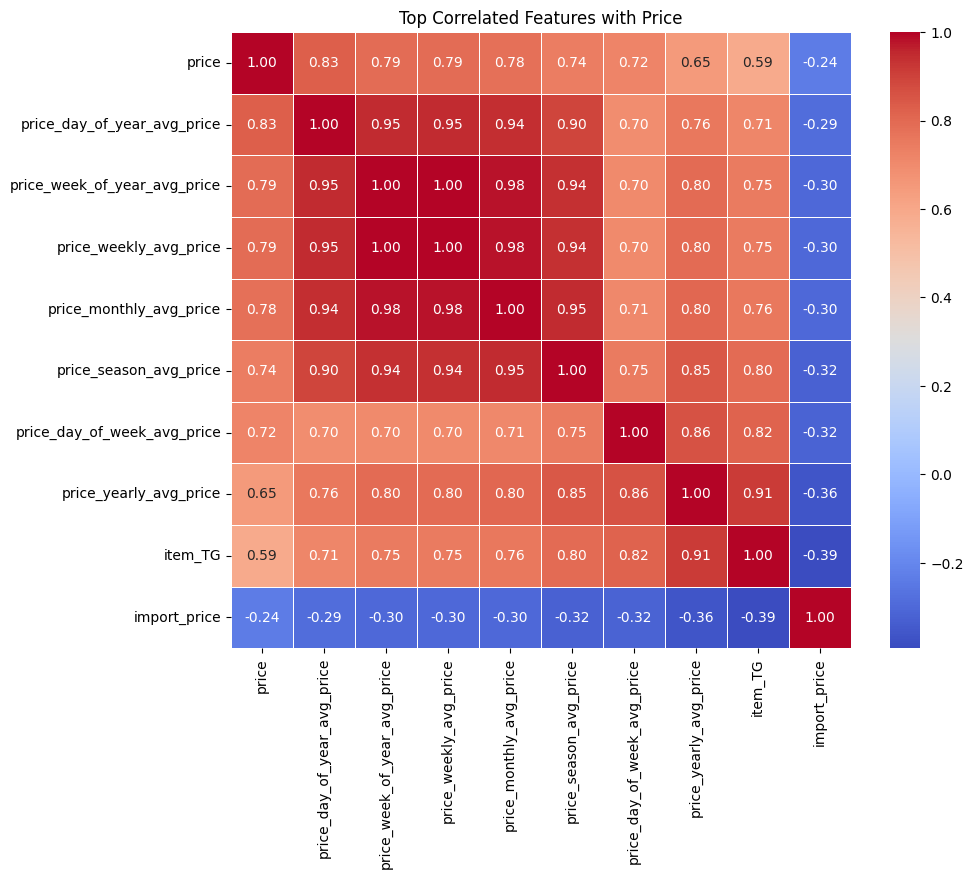

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# price와의 상관 관계가 높은 feature들 상위 N개 선택 (예: 상위 10개)
top_features = train.corr()['price'].abs().sort_values(ascending=False).head(10).index

# 선택된 feature들에 대한 상관 행렬 계산
correlation_matrix = train[top_features].corr()

# Heatmap으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Top Correlated Features with Price')
plt.show()


In [ ]:
!pip install shap

In [ ]:
# import shap

# # 모델을 생성하고 훈련한 후
# model = LGBMRegressor(random_state=SEED)
# model.fit(train_ft, target)

# # SHAP 값을 계산
# explainer = shap.Explainer(model)
# shap_values = explainer.shap_values(train_ft)


In [ ]:
# # SHAP summary plot 그리기
# shap.summary_plot(shap_values, train_ft, plot_type='bar')

# # 그래프를 저장하거나 표시할 수 있습니다.
# plt.show()

In [ ]:
# # 각 feature의 평균 SHAP 값 계산
# feature_importance = np.abs(shap_values).mean(axis=0)

# # 중요도가 높은 상위 N개의 feature 선택 (예: 상위 10개)
# top_features_indices = np.argsort(feature_importance)[-10:][::-1]
# top_features = train_ft.columns[top_features_indices]

# top_features

In [ ]:
# selected_features = train.corr()['price'][abs(train.corr()['price']) >= 0.05].index
# selected_features

In [ ]:
# selected_cols = selected_features.tolist() + top_features.tolist()
# selected_cols = list(set(selected_cols))
# selected_cols.remove('price')
# len(selected_cols)


### Select K best

In [ ]:
# from sklearn.feature_selection import SelectPercentile
# select = SelectPercentile(percentile=50)
# x_train = select.fit_transform(train_ft,target)
# scores = cross_val_score(model_ensemble,x_train,target,cv=cv,n_jobs=-1,scoring=scorer)
# scores.mean()

In [ ]:
# main_cols = list(select.get_feature_names_out())
# main_cols

In [ ]:
train_ft = train[cols].copy()
test_ft = test[cols].copy()
# train_ft = train[selected_cols].copy()
# test_ft = test[selected_cols].copy()

In [ ]:
target

0           0.0
1           0.0
2        1728.0
3        1408.0
4        1250.0
          ...  
59392     468.0
59393     531.0
59394     574.0
59395     523.0
59396     529.0
Name: price, Length: 59397, dtype: float64

# Scaling

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit_transform(train_ft)

In [ ]:
# train_ft = scaler.fit_transform(train_ft)
# test_ft = scaler.transform(test_ft)

#MinMax : LGBM 771

In [ ]:
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()

# scaler.fit_transform(train_ft)
# train_ft = scaler.fit_transform(train_ft)
# test_ft = scaler.transform(test_ft)

In [ ]:
# from sklearn.preprocessing import PowerTransformer
# scaler = PowerTransformer()

# scaler.fit_transform(train_ft)
# train_ft = scaler.fit_transform(train_ft)
# test_ft = scaler.transform(test_ft)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit_transform(train_ft)
train_ft = scaler.fit_transform(train_ft)
test_ft = scaler.transform(test_ft)

# 학습, 검증, 예측

## 모델 학습 및 검증 (RMSE)

In [ ]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_valid, pred):
    mse = mean_squared_error(y_valid, pred)
    return np.sqrt(mse)

In [ ]:
from sklearn.metrics import make_scorer
scorer = make_scorer(rmse, greater_is_better=False)

- LGBM

In [ ]:
# cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

model2 = LGBMRegressor(random_state=SEED)
rmse_scores = cross_val_score(model2, train_ft, target, cv=cv, scoring=scorer, n_jobs=-1)
np.mean(np.abs(rmse_scores))

# MinMax Scaler : 771.4168808720348
# Robust Scaler : 771.9089927370972
# Power Transformer : 769.7831084498569
# Standard Scaler : 766.54575515997

# selected_cols : 790.5937230793568

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


766.54575515997

In [ ]:
from catboost import CatBoostRegressor

cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

model = CatBoostRegressor(random_state=SEED, verbose=1)
rmse_scores = cross_val_score(model, train_ft, target, cv=cv, scoring=scorer, n_jobs=-1)
np.mean(np.abs(rmse_scores))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


748.561483945881

- 모델별 / 앙상블

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima_model import ARIMA
# from fbprophet import Prophet

# 모델 정의
models = {
    # 'LGBM': LGBMRegressor(random_state=SEED),
    # 'RandomForest': RandomForestRegressor(random_state=SEED),
    'CatBoost': CatBoostRegressor(random_state=SEED, verbose=0),
    # 'XGBoost': XGBRegressor(random_state=SEED),
    # 'LinearRegression': LinearRegression(),
    # 'LogisticRegression' : LogisticRegressor
    # 'ARIMA': ARIMA(train_target, order=(5,1,0)),  # ARIMA 모델에 맞는 order를 설정해야 합니다.
    # 'Prophet': Prophet(),
}

# 모델별 교차 검증 수행
for model_name, model in tqdm(models.items()):
    rmse_scores = cross_val_score(model, train_ft, target, cv=cv, scoring=scorer, n_jobs=-1)
    avg_rmse = np.mean(np.abs(rmse_scores))
    print(f'{model_name} RMSE: {avg_rmse}')

# 모델별 평균 RMSE 출력
# RF 803 / LGBM 771* / Cat 746* / XGB 787* / LR 970

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CatBoost RMSE: 748.561483945881


In [ ]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ("rf", RandomForestRegressor(random_state=SEED)),
    ("lgbm",LGBMRegressor(random_state=SEED)),
    ("xgboost",XGBRegressor(random_state=SEED)),
    ("cat",CatBoostRegressor(random_state=SEED,iterations=200))
]

params = {
    "estimators" : estimators,
    "final_estimator" : LinearRegression(),
    "cv" : cv,
    "n_jobs":-1
}

model_ensemble= StackingRegressor(**params)

rmse_scores = cross_val_score(model_ensemble, train_ft, target, cv=cv, scoring=scorer, n_jobs=-1)
np.mean(np.abs(rmse_scores))

#Stacking (rf, lgbm, xgb, cat) : 755.4509535074882 (실제점수 : 797.10784)

## 예측

- 단일 모델

In [ ]:
# !pip install optuna

In [ ]:
# import optuna
# from catboost import CatBoostRegressor

# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 50, 300),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'random_strength': trial.suggest_float('random_strength', 0.1, 1),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 30),
#         # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50)
#     }

#     catboost = CatBoostRegressor(**params, random_state=SEED, verbose=0)
#     rmse_scores = cross_val_score(catboost, train_ft, target, cv=cv, scoring=scorer, n_jobs=-1)
#     return np.mean(np.abs(rmse_scores))

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)  # 적절한 횟수로 변경 가능

# print('Number of finished trials: ', len(study.trials))
# print('Best trial:')
# trial = study.best_trial

# print('Value: ', trial.value)
# print('Params: ')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')


[I 2023-11-02 13:56:30,260] A new study created in memory with name: no-name-7178672b-d953-49f7-ae80-3a4e9cc01920
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# params =  {'iterations': 240, 'depth': 9, 'learning_rate': 0.21535025986270043, 'random_strength': 0.15063351798000446, 'bagging_temperature': 0.31587572501561145, 'border_count': 180, 'l2_leaf_reg': 12.802760362311169}

# catboost = CatBoostRegressor(**params, random_state=SEED, verbose=0)

In [ ]:
# model = catboost
# model.fit(train_ft,target)

In [ ]:
# pred = model.predict(test_ft)
# pred

In [ ]:
# submission['answer'] = pred
# submission.to_csv('submission03_1101.csv', index=False)
# #816.7408034889

In [ ]:
# submission

- 앙상블 모델

In [ ]:
model = model_ensemble
model.fit(train_ft,target)

In [ ]:
pred = model.predict(test_ft)
pred

In [ ]:
submission['answer'] = pred
submission.to_csv('submission02_1101.csv', index=False)
#797.1078452585

In [ ]:
submission

In [ ]:
#submission01_1101 :  전체 feature, lgbm단일, holdout
#	849.8694502187